# Modal analysis of a cooling tower

## Gmsh model

You can find modeling instructions at:
[Creating quadrilateral surface meshes with gmsh](https://bbanerjee.github.io/ParSim/fem/meshing/gmsh/quadrlateral-meshing-with-gmsh/)

![image1.png](https://s2.loli.net/2025/03/13/eaPDWJiNug8qvxU.png)

In [1]:
import gmsh
import sys
import math
import json

In [2]:
# Initialize gmsh
gmsh.initialize()

gmsh.model.add("forma11c_gmsh")

``forma11c_profile.json`` can be downloaded from [here](https://biba1632.gitlab.io/code-aster-manuals/docs/validation/v2.08.011.html#geometry-and-mesh)

In [3]:
# Read the profile coordinates
file_id = open("forma11c_profile.json", "r")
coords = json.load(file_id)
file_id.close()

In [4]:
# Set a default element size
el_size = 1.0

# Add profile points
v_profile = []
for coord in coords:
    v = gmsh.model.occ.addPoint(coord[0], coord[1], coord[2], el_size)
    v_profile.append(v)

In [5]:
# Add spline going through profile points
l1 = gmsh.model.occ.addBSpline(v_profile)
# Create copies and rotate
l2 = gmsh.model.occ.copy([(1, l1)])
l3 = gmsh.model.occ.copy([(1, l1)])
l4 = gmsh.model.occ.copy([(1, l1)])

# Rotate the copy
gmsh.model.occ.rotate(l2, 0, 0, 0, 0, 0, 1, math.pi / 2)
gmsh.model.occ.rotate(l3, 0, 0, 0, 0, 0, 1, math.pi)
gmsh.model.occ.rotate(l4, 0, 0, 0, 0, 0, 1, 3 * math.pi / 2)

In [6]:
# Sweep the lines
surf1 = gmsh.model.occ.revolve([(1, l1)], 0, 0, 0, 0, 0, 1, math.pi / 2)
surf2 = gmsh.model.occ.revolve(l2, 0, 0, 0, 0, 0, 1, math.pi / 2)
surf3 = gmsh.model.occ.revolve(l3, 0, 0, 0, 0, 0, 1, math.pi / 2)
surf4 = gmsh.model.occ.revolve(l4, 0, 0, 0, 0, 0, 1, math.pi / 2)

In [7]:
# Join the surfaces
surf5 = gmsh.model.occ.fragment(surf1, surf2)
surf6 = gmsh.model.occ.fragment(surf3, surf4)
surf7 = gmsh.model.occ.fragment(surf5[0], surf6[0])

In [8]:
gmsh.model.occ.remove_all_duplicates()
gmsh.model.occ.synchronize()

In [9]:
num_nodes_circ = 15
for curve in gmsh.model.occ.getEntities(1):
    gmsh.model.mesh.setTransfiniteCurve(curve[1], num_nodes_circ)

In [10]:
num_nodes_vert = 32
vertical_curves = [7, 10, 13, 17]
for curve in vertical_curves:
    gmsh.model.mesh.setTransfiniteCurve(curve, num_nodes_vert)

In [11]:
for surf in gmsh.model.occ.getEntities(2):
    gmsh.model.mesh.setTransfiniteSurface(surf[1])

In [12]:
gmsh.option.setNumber("Mesh.RecombineAll", 1)
gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)
gmsh.option.setNumber("Mesh.Recombine3DLevel", 2)
gmsh.option.setNumber("Mesh.ElementOrder", 1)

In [13]:
# Important:
# Note that we use names to distinguish groups, so please do not overlook this!
# We use the "Boundary" group to include 4 lines
gmsh.model.addPhysicalGroup(dim=1, tags=[6, 9, 12, 15], tag=1, name="Boundary")

1

In [14]:
# Generate mesh
gmsh.model.mesh.generate(dim=2)

In [15]:
gmsh.option.setNumber("Mesh.SaveAll", 1)
gmsh.write("forma11c.msh")

In [16]:
gmsh.fltk.run()

## To OpenSeesPy Model

In [17]:
import openseespy.opensees as ops
import opstool as opst

In [18]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)
E, nu, rho = 2.76e10, 0.166, 2244.0  # Pa, kg/m3
ops.nDMaterial("ElasticIsotropic", 1, E, nu, rho)
secTag = 11
ops.section("PlateFiber", secTag, 1, 0.305)

In [19]:
GMSH2OPS = opst.pre.Gmsh2OPS(ndm=3, ndf=6)

In [20]:
GMSH2OPS.read_gmsh_file("forma11c.msh")

Info:: 1 Physical Names.
Info:: 1821 Nodes; MaxNodeTag 1821; MinNodeTag 1.
Info:: 2009 Elements; MaxEleTag 2009; MinEleTag 1.
Info:: Geometry Information >>>
53 Entities: 37 Point; 12 Curves; 4 Surfaces; 0 Volumes.

Info:: Physical Groups Information >>>
1 Physical Groups.
Physical Group names: ['Boundary']

Info:: Mesh Information >>>
1821 Nodes; MaxNodeTag 1821; MinNodeTag 1.
1972 Elements; MaxEleTag 2009; MinEleTag 1.



In [21]:
# Create OpenSeesPy node commands based on all nodes defined in the GMSH file
node_tags = GMSH2OPS.create_node_cmds()

In [22]:
dim_entity_tags = GMSH2OPS.get_dim_entity_tags()
dim_entity_tags_2D = [item for item in dim_entity_tags if item[0] == 2]

In [23]:
# Create OpenSeesPy element commands for specific entities
ele_tags_n4 = GMSH2OPS.create_element_cmds(
    ops_ele_type="ASDShellQ4",  # OpenSeesPy element type
    ops_ele_args=[secTag],  # Additional arguments for the element (e.g., section tag)
    dim_entity_tags=dim_entity_tags_2D,
)

Using ASDShellQ4 - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


In [24]:
boundary_dim_tags = GMSH2OPS.get_boundary_dim_tags(physical_group_names="Boundary", include_self=True)
boundary_dim_tags

[(0, 55), (0, 59), (0, 61), (0, 63), (1, 6), (1, 9), (1, 12), (1, 15)]

In [25]:
fix_ntags = GMSH2OPS.create_fix_cmds(dim_entity_tags=boundary_dim_tags, dofs=[1] * 6)

In [26]:
removed_node_tags = opst.pre.remove_void_nodes()

Info:: Free nodes with tags [57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 
78, 79, 80, 81, 82, 83, 84, 85] have been removed!

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

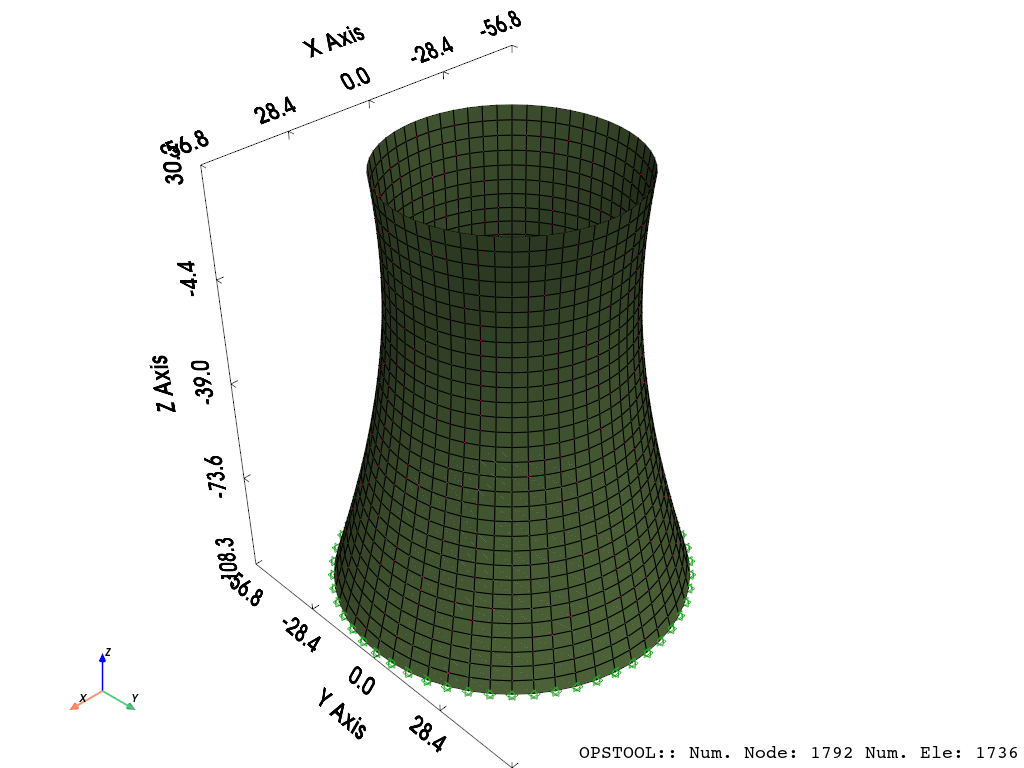

In [27]:
opst.vis.pyvista.set_plot_props(notebook=True)
opst.vis.pyvista.plot_model(show_outline=True).show(jupyter_backend="jupyterlab")

In [28]:
opst.post.save_eigen_data(odb_tag="eigen", mode_tag=60)

Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Eigen data has been saved to _OPSTOOL_ODB/EigenData-eigen.nc!

OPSTOOL ::  Loading eigen data from _OPSTOOL_ODB/EigenData-eigen.nc ...

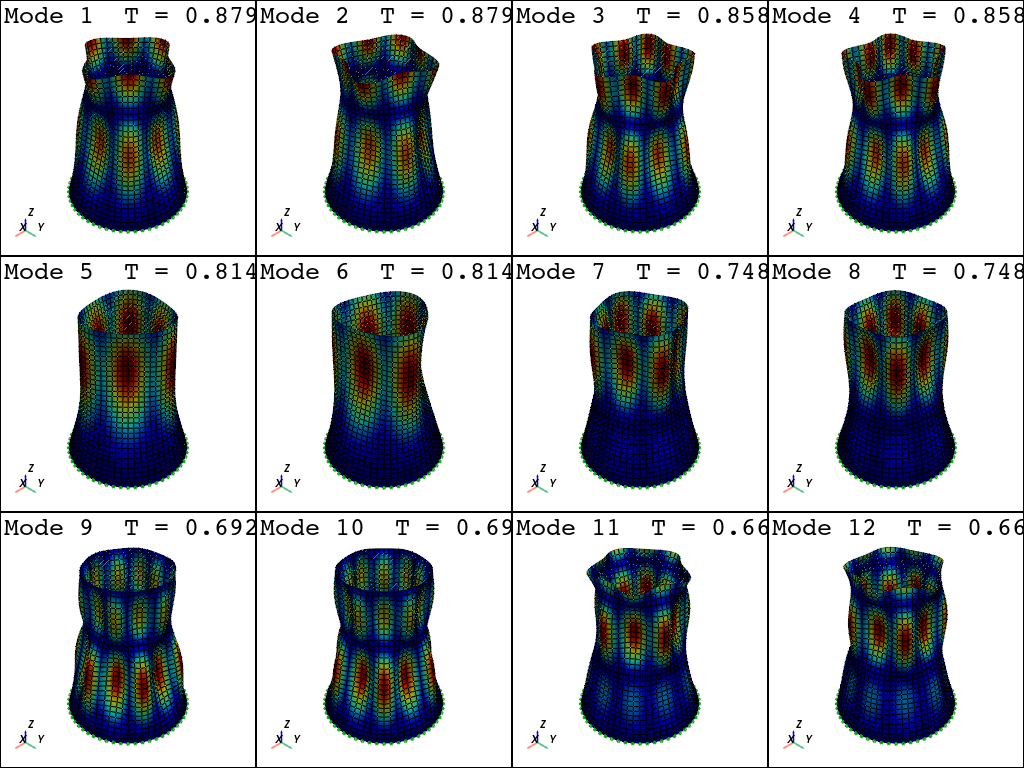

In [34]:
fig = opst.vis.pyvista.plot_eigen(mode_tags=12, odb_tag="eigen", subplots=True)
fig.show(jupyter_backend="jupyterlab")

In [30]:
modal_props, eigen_vectors = opst.post.get_eigen_data(odb_tag="eigen")
modal_props = modal_props.to_pandas()
modal_props.head()

OPSTOOL ::  Loading eigen data from _OPSTOOL_ODB/EigenData-eigen.nc ...

Properties,eigenLambda,eigenOmega,eigenFrequency,eigenPeriod,partiFactorMX,partiFactorMY,partiFactorRMZ,partiFactorMZ,partiFactorRMX,partiFactorRMY,...,partiMassRatiosRMZ,partiMassRatiosMZ,partiMassRatiosRMX,partiMassRatiosRMY,partiMassRatiosCumuMX,partiMassRatiosCumuMY,partiMassRatiosCumuRMZ,partiMassRatiosCumuMZ,partiMassRatiosCumuRMX,partiMassRatiosCumuRMY
modeTags,,,,,,,,,,,,,,,,,,,,,
1,51.13809,7.151090,1.138131,0.878633,2.133296e-10,6.395783e-11,-5.687698e-10,2.489633e-11,-2.639758e-10,6.281351e-09,...,7.347386e-28,2.546785e-27,1.156468e-28,6.548041e-26,1.869924e-25,1.680773e-26,7.347386e-28,2.546785e-27,1.156468e-28,6.548041e-26
2,51.13809,7.151090,1.138131,0.878633,4.024028e-10,-5.398455e-11,-8.745127e-10,-9.774598e-12,-1.394169e-09,1.480870e-08,...,1.736969e-27,3.925721e-28,3.225792e-27,3.639476e-25,8.523324e-25,2.878232e-26,2.471707e-27,2.939357e-27,3.341439e-27,4.294281e-25
3,53.64215,7.324080,1.165664,0.857880,3.396294e-10,-4.563913e-10,3.302614e-09,-1.937277e-12,1.743117e-08,1.145287e-08,...,2.477282e-26,1.542073e-29,5.042644e-25,2.176878e-25,1.326282e-24,8.846298e-25,2.724453e-26,2.954778e-27,5.076058e-25,6.471158e-25
4,53.64215,7.324080,1.165664,0.857880,-6.006892e-11,-2.575128e-10,-1.834748e-10,-4.978899e-12,9.513005e-09,-2.254505e-09,...,7.645618e-29,1.018564e-28,1.501899e-25,8.435437e-27,1.341108e-24,1.157100e-24,2.732098e-26,3.056634e-27,6.577957e-25,6.555512e-25
5,59.58843,7.719354,1.228573,0.813952,4.042192e-10,6.548266e-10,5.770587e-10,1.697122e-12,-2.767511e-08,1.639054e-08,...,7.563098e-28,1.183444e-29,1.271112e-24,4.458529e-25,2.012468e-24,2.918972e-24,2.807729e-26,3.068468e-27,1.928908e-24,1.101404e-24


In [31]:
modal_props.loc[[1, 47, 48, 60], "eigenFrequency"]

modeTags
1     1.138131
47    2.875771
48    2.875771
60    3.196797
Name: eigenFrequency, dtype: float64

You can compare this with Code-Aster, which uses DKT shell elements.
See ~
[Model C: Modal analysis of a cooling tower¶](https://biba1632.gitlab.io/code-aster-manuals/docs/validation/v2.08.011.html#model-c-modal-analysis-of-a-cooling-tower)

![image2.png](https://s2.loli.net/2025/03/13/5G3zqP4JfTOmg2o.png)